#### Опис алгоритму роботи агента

Для реалізації роботи агента був розроблений класс Agent.<br>
Екземпляр цього класу при створенні приймає 3 аргументи: номер початкової вершини, номер кінцевої вершини та граф-дорогу (екземпляр класу Graph).<br>
Алгоритм роботи агента полягає у циклічному виконанні 3 операцій: операція \_tell аналізує середовище навколо агента та формує деревоподібну структуру routes що містить сусідні вершини та сусідні до сусідніх; операція \_ask виконує обрахунок оптимальної вершини для переходу шляхом порівняння відстані від усіх видимих вершин до кінцевої виконуючи рекурсивний обхід структури routes (див. лаб2 для формули обрахунку відстані) та вибору вершини яка набільше наблизить агента до кінцевої точки; операція \_do реалізує рух агента до наступної вершини або назад, в залежності від результату функції \_ask. Вищеописані кроки повторюються до тих пір, пока агент не прибуде до кінцевої вершини.

In [1]:
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

In [2]:
class Graph:
    def __init__(self, vertices=25, edges_to_remove=10):
        self.vertices = vertices
        self.width = int(vertices ** 0.5)
        self.structure = {i: [] for i in range(vertices)}
        self._form_structure()
        self._remove_edges(edges_to_remove)
        self._coords = {}
        self._calc_coords()

    def _form_structure(self):
        for i in range(self.vertices-1):
            if (i+1) % self.width != 0:
                self.structure[i].append(i+1)
                self.structure[i+1].append(i)
            if i < (self.vertices - self.width):
                self.structure[i].append(i+self.width)
                self.structure[i+self.width].append(i)

    def _calc_coords(self):
        for i in range(self.width):
            for t in range(self.width):
                self._coords[t+(i*5)] = [i, t]

    def _add_edge(self, v1, v2):
        self.structure[v1].append(v2)
        self.structure[v2].append(v1)

    def _delete_edge(self, v1, v2):
        self.structure[v1].remove(v2)
        self.structure[v2].remove(v1)

    def _is_connected(self):
        not_visited = [i for i in range(self.vertices)]
        queue = [0]

        while queue:
            s = queue.pop(0)
            for neighbor in self.structure[s]:
                if neighbor in not_visited:
                    not_visited.remove(neighbor)
                    queue.append(neighbor)

        return not bool(not_visited)

    def _remove_edges(self, count):
        i = 0
        while i < count:
            vertex = random.randint(0, len(self.structure)-1)
            if len(self.structure[vertex])-1 == 0:
                continue
            neighbor = random.randint(0, len(self.structure[vertex])-1)
            neighbor = self.structure[vertex][neighbor]

            self._delete_edge(vertex, neighbor)
            if not self._is_connected():
                self._add_edge(vertex, neighbor)
            else:
                i += 1

    def get_neighs(self, vert):
        a = {}
        for i in self.structure[vert]:
            a[i] = self._coords[i]
        return a

    def get_coords(self, vertex):
        return self._coords[vertex]

In [3]:
def best_route(agent, routes, best=float('inf'), vert=None, parent=None):
    for route in routes:
        if (route not in agent.hist) and (route != agent.pos):
            x, y = agent.road.get_coords(route)
            dist = abs(x - agent.des_crds[0]) + abs(y - agent.des_crds[1])
            if dist < best:
                best = dist
                vert = parent if (parent is not None) else route

            if isinstance(routes, dict):
                best, vert = best_route(agent, routes[route], best, vert, route)

    return best, vert

In [4]:
class Agent():
    def __init__(self, pos, des, road):
        self.pos = pos
        self.des = des
        self.des_crds = road.get_coords(des)
        self.road = road
        self.routes = {}
        self.hist = []
        self.map = []

    def _tell(self):
        neighs = self.road.get_neighs(self.pos)
        self.routes = {}
        for i in neighs:
            self.routes[i] = list(self.road.get_neighs(i).keys())

    def _ask(self):
        _, vert = best_route(self, self.routes)
        return vert

    def _do(self, vert):
        if vert is None:
            vert = self.map[-1]
            self.map.pop()
        else:
            self.map.append(self.pos)

        self.hist.append(self.pos)
        self.pos = vert

    def move(self):
        while self.pos != self.des:
            self._tell()
            vert = self._ask()
            self._do(vert)
        self.hist.append(self.pos)

In [5]:
def draw_graph(graph):
    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')

    coords = []
    for i in range(graph.width):
        for t in range(graph.width):
            coords.append([(i+1)*50,(t+1)*50])
            circle = Circle(((i+1)*50, (t+1)*50), 8, fill=True, color='black')
            ax.add_patch(circle)
            ax.text((i+1)*50, (t+1)*50, t+(i*5),
                    fontsize=10, color='white', ha='center', va='center')

    for i in graph.structure:
        for t in graph.structure[i]:
            line = Line2D([coords[i][0], coords[t][0]],
                          [coords[i][1], coords[t][1]],
                          color='black', linewidth=1)
            ax.add_line(line)

    ax.plot()
    ax.axis('off')
    plt.show()

    return coords

In [6]:
def draw_agent(agent, coords):
    print('Initial vertex:', agent.hist[0])
    print('Final vertex:', agent.hist[-1])
    print('Steps:', len(agent.hist)-1)
    print('Way:', end=' ')
    for i in agent.hist:
        print(i, end=f'{"" if i == agent.hist[-1] else " -> "}')
    print('\n')

    fig, ax = plt.subplots()
    ax.set_aspect('equal', 'box')

    pairs = [(agent.hist[i], agent.hist[i+1]) for i in range(len(agent.hist)-1)]
    pairs.append((agent.des, agent.des))

    for a, b in pairs:
        line = Line2D([coords[a][0], coords[b][0]],
                        [coords[a][1], coords[b][1]], color='black', linewidth=1)
        ax.add_line(line)
        x, y = coords[a]
        circle = Circle((x, y), 8, fill=True, color='black')
        ax.add_patch(circle)
        ax.text(x, y, a, fontsize=10, color='white', ha='center', va='center')

    ax.plot()
    ax.axis('off')
    plt.show()

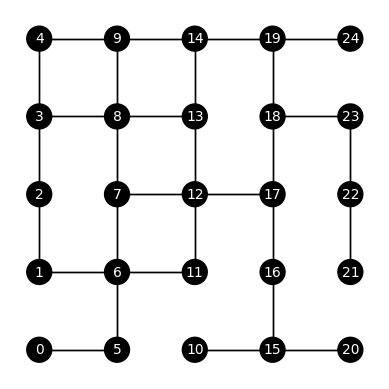

In [7]:
graph = Graph()
crds = draw_graph(graph)

Initial vertex: 0
Final vertex: 24
Steps: 8
Way: 0 -> 5 -> 6 -> 7 -> 8 -> 9 -> 14 -> 19 -> 24



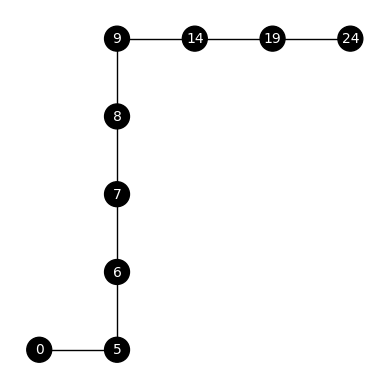

In [8]:
rand = False
a = random.randint(0, 24) if rand else 0
b = random.randint(0, 24) if rand else 24

agent = Agent(a, b, graph)
agent.move()

draw_agent(agent, crds)

#### Висновок
Під час виконання лабораторної роботи я отримав практичні навички роботи з агентами на основі знань шляхом вдосконалення інтелектуального агента з попередньої лабораторної роботи